<h1>CORN OR MAIZE LEAF DISEASE DETECTOR</h1>

<h2>IMPORTING LIBRARIES AND CREATING CALLBACKS</h2>

In [1]:
import os #Inbuilt python library that lets us interact with operating system
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
checkpoint_path = 'trainingmyset/.cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path) #Used to get the directory name from the specified path
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only=True ,verbose=1)

In [3]:
class myCall(tf.keras.callbacks.Callback):
    def set_model(self, model):
        self.model = model
    def on_epoch_end(self, epoch, logs ={}):
        if logs.get('accuracy') > 0.99 :
            print("\n Reached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [4]:
callbacks = myCall() #Creating an object

<H2>ADDING THE IMAGES TO TENSORFLOW DATASETS</H2>
<h3>(IMPLEMENTING TENSORFLOW INPUT PIPELINING)</h3>

<P>Creating constants for items that will be used frequently in the program</P>

In [5]:
img_size = 256
batch_size = 32
epochs = 30

<p>Adding the image files to the dataset</p>

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = batch_size,
    label_mode='int'
)

Found 4188 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [8]:
num_classes = len(class_names)

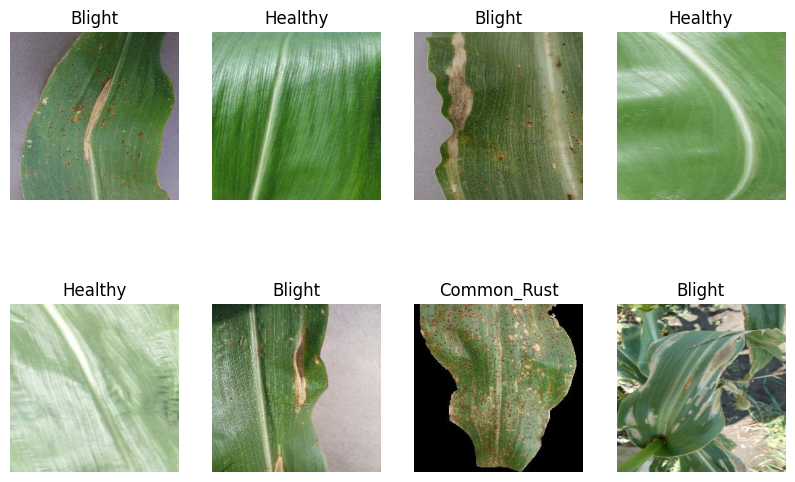

In [9]:
#Splitting the figure
plt.figure(figsize =(10,10))

#Iterating over the dataset
for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

<h2>SPLITTING THE DATA INTO TRAIN AND TEST SETS</h2>

<p>Training Set = 80%</p>
<p>Validation Set = 10%</p>
<p>Test Set = 10%</p>

In [10]:
training_len = int(0.8* len(dataset))
training_set = dataset.take(training_len)
remain_set = dataset.skip(training_len)
print(f"Length of training set = {training_len} elements")

test_len = int(0.1* len(dataset))
test_set = remain_set.take(test_len)
valid_set = remain_set.skip(test_len)
print(f"Length of test set = {test_len} elements")
print(f"Length of validation set = {len(valid_set)} elements")

Length of training set = 104 elements
Length of test set = 13 elements
Length of validation set = 14 elements


<p>We will use the .prefetch method since it prefetches batches of data in the background while the model is executing training steps, which makes the problem solving faster.</p>

<p>The .cache method is used to cache data, which can significantly improve the data loading speed.</p>

In [11]:
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_set = valid_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
rescale_and_resize = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(img_size,img_size), #this will make sure that all the images are in the required scale
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

<H2>BUILDING THE MODEL</H2>

<p>Adding the CNN layers</p>

In [14]:
input_shape = (batch_size,256,256,3)
model = tf.keras.Sequential([
    rescale_and_resize,
    data_augmentation,
    tf.keras.layers.Conv2D( 32, (3,3), activation = 'relu' , input_shape = input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(26, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

<p>Compiling the model</p>

In [15]:
model.compile( optimizer = 'adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.build(input_shape = input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [18]:
model.fit(x=training_set,epochs=epochs,batch_size=batch_size,validation_data=valid_set,callbacks=[callbacks,cp_callback],verbose=1)

Epoch 1/30


104/104 [==============================] - ETA: 0s - loss: 0.9344 - accuracy: 0.5847
Epoch 1: saving model to trainingmyset\.cp.ckpt
104/104 [==============================] - 250s 2s/step - loss: 0.9344 - accuracy: 0.5847 - val_loss: 0.7522 - val_accuracy: 0.7703
Epoch 2/30
104/104 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8065
Epoch 2: saving model to trainingmyset\.cp.ckpt
104/104 [==============================] - 221s 2s/step - loss: 0.4829 - accuracy: 0.8065 - val_loss: 0.5370 - val_accuracy: 0.8018
Epoch 3/30
104/104 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8332
Epoch 3: saving model to trainingmyset\.cp.ckpt
104/104 [==============================] - 241s 2s/step - loss: 0.4270 - accuracy: 0.8332 - val_loss: 0.5933 - val_accuracy: 0.7995
Epoch 4/30
104/104 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8453
Epoch 4: saving model to trainingmyset\.cp.ckpt
104/104 [=================

In [19]:
model.evaluate(test_set)

13/13 [==============================] - 15s 392ms/step - loss: 0.2513 - accuracy: 0.9303


[0.25134581327438354, 0.9302884340286255]

In [20]:
model.save('Model.keras')